# Forecasting Cost-Per-Click Using Explainable Deep Learning:
## Multivariate Modelling of the Competitive Online Bidding Landscape and Budgeting Strategies

Fynn Oldenburg, Qiwei Han and Maximilian Kaiser

-------------

This folder contains the implementation of our proposed modelling procedure for Google cost-per-click prediction (CPC) together with a small anonymized subsample of the data used in our study. The demo notebook is intended as a transparent walkthrough showing how each individual module works. The code can also be run as a whole from terminal by calling main.py.

-------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1 Input data file
The input data needs to be in the exact same format as the demo_data.csv used here and stored in the /data directory. No missing data or missing time steps are allowed so all preprocessing needs to be done beforehand.

In [2]:
pd.read_csv('data/demo_data.csv').head(5)

,adwordscustomerid,category,adcost,adclicks,impressions,cpc,adbudget,time_idx,date,month,dayofweek,dayofyear
0,id_0001,Computers_Electronics_and_Technology,16.143085,15,149,1.076206,64.511115,0,2019-01-01,1,1,1
1,id_0001,Computers_Electronics_and_Technology,38.065914,29,467,1.312618,64.511115,1,2019-01-02,1,2,2
2,id_0001,Computers_Electronics_and_Technology,69.290270,57,469,1.215619,64.511115,2,2019-01-03,1,3,3
3,id_0001,Computers_Electronics_and_Technology,26.558758,28,389,0.948527,64.511115,3,2019-01-04,1,4,4
4,id_0001,Computers_Electronics_and_Technology,22.276663,20,179,1.113833,64.511115,4,2019-01-05,1,5,5


# 2 Model configuration
User input parameters for model training (need to be defined in the main.py as well)

In [3]:
CONFIG = {
    'data_path': 'data/demo_data.csv',         # data file path
    'target_advertiser_id': ['id_0001'],       # advertiser to predict (multiple possible)
    'max_horizon': 60,                         # longest horizon to predict (max look forward)
    'min_horizon': 14,                         # shortest horizon to predict (min look forward)
    'encoder_length': 90,                      # encoder window length (look back)
    'holdout_split_idx': 1000,                 # time index to split holdout data
    'include_competition': True,               # set False to benchmark against model without competition
    'model_path': 'trained_models/',           # directory to save trained model
    'cluster_path': 'cluster_results/',        # directory to save trained model
    'name_prefix': 'demo'                      # prefix to add to cluster result and model 
}                                                # (model name will also append advertiser id)

A quick overview of the selected primary advertiser CPC development

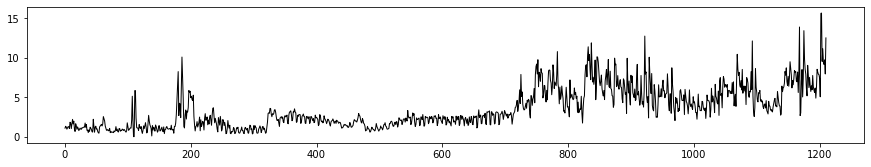

In [4]:
plot_df = pd.read_csv('data/demo_data.csv')
adv_plot_df = plot_df[plot_df.adwordscustomerid == CONFIG['target_advertiser_id'][0]]
plt.figure(figsize=(15,2.5))
plt.plot(adv_plot_df.time_idx, adv_plot_df.cpc, c='black', lw=1)
plt.show()

# 3 Time series clustering
We conduct distance-based time series clustering to identify groups of advertisers with similar CPC development to use them as covariates for predicting each others future CPC. If a clustering with the same prefix already exists in the /cluster_results directory, no new clustering is generated but the existing one is loaded.

In [5]:
import clustering

clusterer = clustering.distanceClustering(CONFIG)
clust_assignment = clusterer.dtw_kmeans(k_min=7, k_max=7, k_step=1)

clust_assignment.head(5)

... load existing cluster assignment


adwordscustomerid
id_0001    6
id_0002    6
id_0003    6
id_0004    6
id_0005    6
Name: clust, dtype: int64

# 4 Data formatting
PyTorch training and validation data sets as well as dataloaders are generated. The output variables are lists containing one element per target advertiser defined in CONFIG.

In [6]:
import formatting

formatter = formatting.dataFormatter(CONFIG, clustering=clust_assignment)
adv_data, adv_holdout = formatter.get_adv_datasets()

adv_data[0].head(5)

,adwordscustomerid,category,adcost,adclicks,impressions,cpc,adbudget,time_idx,date,month,...,cpc_id_0002,cpc_id_0003,cpc_id_0004,cpc_id_0005,cpc_id_0006,cpc_id_0007,cpc_id_0008,cpc_id_0009,cpc_id_0010,cpc_id_0011
0,id_0001,Computers_Electronics_and_Technology,16.143085,15,149,1.076206,64.511115,0,2019-01-01,1,...,1.705929,1.941671,2.399189,1.634446,6.293911,2.335637,3.299349,0.600723,0.000000,0.885118
1,id_0001,Computers_Electronics_and_Technology,38.065914,29,467,1.312618,64.511115,1,2019-01-02,1,...,2.279701,1.978007,2.092318,1.460333,4.713427,2.491293,2.245534,0.606821,3.477387,1.668757
2,id_0001,Computers_Electronics_and_Technology,69.290270,57,469,1.215619,64.511115,2,2019-01-03,1,...,1.593603,1.880460,2.142634,1.291313,5.029877,2.521067,2.889605,0.657974,4.300381,0.946883
3,id_0001,Computers_Electronics_and_Technology,26.558758,28,389,0.948527,64.511115,3,2019-01-04,1,...,2.635196,2.048986,2.840680,1.188559,4.928412,2.239193,2.305173,0.547456,8.240421,0.817443
4,id_0001,Computers_Electronics_and_Technology,22.276663,20,179,1.113833,64.511115,4,2019-01-05,1,...,2.899471,1.808209,1.821338,1.222854,4.762749,2.635530,3.674025,0.344047,2.306396,0.618821


In [7]:
train_pydata, valid_pydata = formatter.get_py_datasets(adv_data)
train_pyloader, valid_pyloader = formatter.get_py_dataloaders(train_pydata, valid_pydata)

# 5 Model Training
Training of the Temporal Fusion Transformer. Hyperparameter configuration can be adapted in the /training/tft module. A separate model is trained for every target advertiser defined in the CONFIG. If a model with the same prefix already exists in the /trained_models directory, no new model is generated but the existing one is loaded. The ouput is a list of models.

In [8]:
import training

trainer = training.trainTFT(CONFIG)
models = trainer.train_model(train_pydata, train_pyloader, valid_pyloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train model: demo_tft_id_0001


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2     
3  | prescalers                         | ModuleDict                      | 360   
4  | static_variable_selection          | VariableSelectionNetwork        | 100   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 13.1 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 648   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 648   
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# 6 Agent
The agent module can be used to apply a TFT trained for one advertiser to unseen data. The module provides functions to output the raw predictions, prediction vs actuals scores, feature importances or a prediction visualization.

In [9]:
import agent

adv_i = 0

ag = agent.agentTFT(CONFIG)
ag.predict(
    data=adv_holdout[adv_i],
    prev_data=adv_data[adv_i],
    model=models[adv_i],
    horizon=60
)

**6.1 Get plain prediction values**

In [10]:
ag.prediction.head(10)

1000    4.826531
1001    4.212611
1002    3.469947
1003    3.152533
1004    2.965324
1005    2.888616
1006    3.404832
1007    5.812948
1008    5.130691
1009    4.065784
Name: pred, dtype: float32

**6.2 Get prediction scores**

In [11]:
print('Mean absolute error:', ag.mae)
print('Mean absolute percentage error:', ag.mape)
print('Symmetric mean absolute percentage error:', ag.smape)

Mean absolute error: 1.1813188974625726
Mean absolute percentage error: 0.22804505365025712
Symmetric mean absolute percentage error: 0.2349429851216001


**6.3 Get feature importances**

In [12]:
ag.feature_importance['attention'][:10] # example printing the attention to first
                                        # 10 encoder steps. Several more attributes
                                        # are included in .feature_importance

tensor([0.0146, 0.0115, 0.0113, 0.0094, 0.0087, 0.0090, 0.0141, 0.0129, 0.0100,
        0.0094])

**6.4 Get visualization**

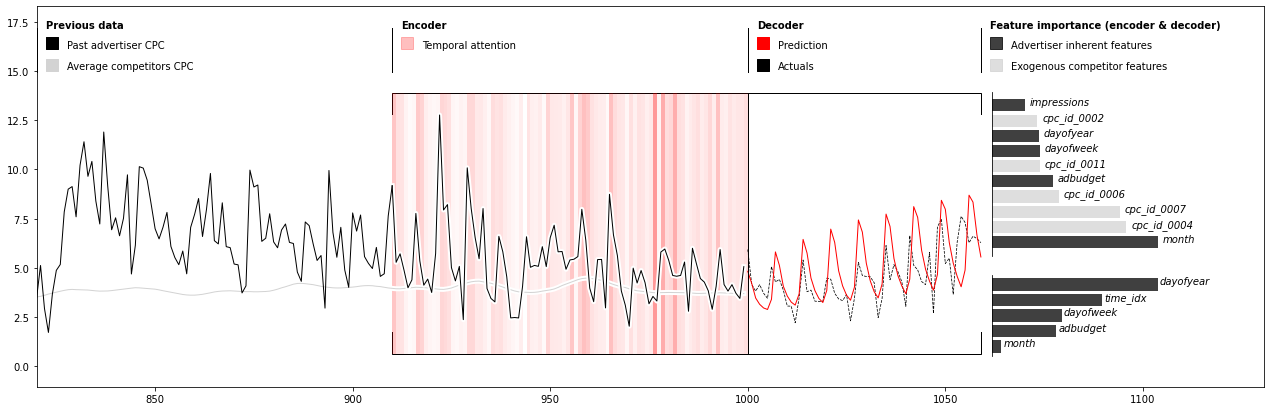

In [13]:
ag.pred_viz()